# Character Mentions (POV) — First half / Second half / Total

This notebook computes **character mention counts** for long novels (e.g., *War and Peace*, *Anna Karenina*).
It reports counts for the **first half**, **second half**, and **the whole book**, and visualizes results with
unique charts (slope chart + donut). The notebook is written to be robust and well-documented: each code cell
is followed by a markdown cell explaining what it does.

**Notes:**
- Designed to run with Python 3.11 and packages in your `requirements.txt` (uses `nltk`, `pandas`, `matplotlib`).
- The notebook auto-detects `.txt` files in `../data/` and will use them; edit `book_path` in the first code cell
  if you want to analyze a different file.


In [13]:
# Imports and setup (safe, part of requirements)
import os, re, math, collections, itertools
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

# Helper: data directory and automatic detection of .txt files
data_dir = os.path.join('..', 'data')
txt_files = []
if os.path.exists(data_dir):
    txt_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.txt')])
print('Data directory:', data_dir)
print('Found text files:', txt_files)

# You may change this to a specific file name from the list above
# Example: book_file = 'War_and_Peace.txt'
book_file = txt_files[0] if txt_files else None
book_path = os.path.join(data_dir, book_file) if book_file else None
print('Selected book:', book_file)


Data directory: ..\data
Found text files: ['The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt', 'The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt']
Selected book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


**What this cell does:**

- Imports necessary libraries (`nltk`, `pandas`, `matplotlib`, and Python stdlib).
- Ensures the NLTK sentence tokenizer (`punkt`) is available.
- Detects `.txt` files in `../data/` and selects the first one by default. Edit `book_file` if you want a different file.

**Why:** This centralises setup and makes the notebook flexible for different books without changing later cells.

In [14]:
# Helper: keep only plausible character names (no 'it', 'the', 'he', etc.)
from pathlib import Path
import pandas as pd

def filter_to_character_names(df,
                              results_dir=None,
                              use_manual_whitelist=True,
                              prefer_multi_token=True):
    """
    Takes a DataFrame with character names in the index and returns a filtered copy
    that keeps only plausible character names (no 'it', 'the', 'he', etc.).
    If manual_name_mapping.csv exists, only canonical names in that file are kept.
    """
    df = df.copy()
    df.index = df.index.astype(str)

    # --- resolve results dir SAFELY ---
    if results_dir is None:
        # Don't reference RESULTS_DIR directly; use globals().get(...)
        rd_global = globals().get('RESULTS_DIR')
        if rd_global is not None:
            results_dir = Path(rd_global)
        else:
            NOTEBOOK_DIR = Path.cwd()
            PROJECT_ROOT = NOTEBOOK_DIR.parent   # assuming notebook/ under project root
            results_dir = PROJECT_ROOT / "results"

    results_dir = Path(results_dir)
    results_dir.mkdir(parents=True, exist_ok=True)

    # --- canonical whitelist from manual_name_mapping.csv, if present ---
    if use_manual_whitelist:
        manual_csv = results_dir / "manual_name_mapping.csv"
        if manual_csv.exists():
            try:
                mm = pd.read_csv(manual_csv)
                canonical = (
                    mm["canonical_name"]
                    .dropna()
                    .astype(str)
                    .str.strip()
                )
                whitelist = {c for c in canonical if c}
                if whitelist:
                    df = df[df.index.isin(whitelist)]
                    print(f"Using canonical whitelist from {manual_csv} ({len(whitelist)} names).")
            except Exception as e:
                print("Could not use manual_name_mapping.csv as whitelist:", e)

    # --- drop pronouns / stopwords and non-name-like things ---
    names = df.index.to_series()
    names_low = names.str.lower()

    stopwords = {
        "and", "the", "a", "an", "it", "he", "she", "they", "we", "i", "you",
        "his", "her", "him", "me", "my", "our", "their", "its", "that", "this",
        "there", "then", "but", "not", "which", "who", "what", "where", "when",
        "to", "of", "in", "on", "for", 'well', 'yes'
    }

    alpha_mask = names.str.match(r"^[A-Z][A-Za-z \-'\.]*$")
    len_mask   = names.str.len() > 2
    stop_mask  = ~names_low.isin(stopwords)

    mask = alpha_mask & len_mask & stop_mask
    df = df[mask]

    # Prefer multi-token names if any exist (e.g. "Anna Karenina")
    if prefer_multi_token:
        multi = df.index.to_series().str.contains(r"\s+")
        if multi.any():
            df = df[multi]

    return df


## Helper: `filter_to_character_names`

This helper function takes a DataFrame whose **index contains name-like tokens** (e.g. `Levin`, `Anna Karenina`, `it`, `the`, …) and returns a *cleaned* DataFrame that keeps only plausible **character names**.

**Inputs**

- `df`: DataFrame indexed by tokens (character candidates).  
- `results_dir` (optional): where results files (like `manual_name_mapping.csv`) live.  
- `use_manual_whitelist`:
  - If `True`, uses `results/manual_name_mapping.csv` to keep only canonical names.  
- `prefer_multi_token`:
  - If `True`, prefers multi-word names (e.g. `Anna Karenina`) when they exist.

**Processing steps**

1. **Canonical whitelist (optional)**  
   - Looks for `results/manual_name_mapping.csv`.  
   - Uses the `canonical_name` column as an *allowed list* of final character names.  
   - Any rows whose index is not in this whitelist are dropped.  
   - This is where you can merge variants like `Anna`, `Karenina` → `Anna Karenina`.

2. **Stopword / pronoun filter**  
   - Removes tokens that are clearly not character names:  
     `it`, `he`, `she`, `and`, `the`, `but`, `to`, `of`, etc.  
   - Also filters out very short tokens (`len <= 2`).

3. **Shape / casing filter**  
   - Keeps only tokens that **start with an uppercase letter** and contain only letters, spaces, hyphens, apostrophes, or periods.  
   - This removes things like `it`, `they`, `there`, and punctuation noise.

4. **Multi-token preference (optional)**  
   - If `prefer_multi_token=True` and there are any names with spaces,
     it keeps only the multi-word names (e.g. `Alexei Alexandrovitch` vs just `Alexei`).

**Why this matters**

All plots that call this helper only show **real characters** (Levin, Vronsky, Anna, etc.), not grammatical junk like `It`, `He`, `The`, `And`. The canonical mapping + filters are your main tools for controlling *who counts as a character* in the visualizations.


In [15]:
# Load & simple Gutenberg-cleaning function
def load_and_clean_text(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f'Book file not found at {path}')
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    # Try to remove Project Gutenberg header/footer if present
    start = re.search(r'\*\*\* *START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if start:
        text = text[start.end():]
    else:
        # fall back to first CHAPTER/BOOK marker if present
        m = re.search(r'\n(CHAPTER|BOOK|PART)\b', text, flags=re.I)
        if m:
            text = text[m.start():]
    end = re.search(r'\*\*\* *END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if end:
        text = text[:end.start()]
    # normalize whitespace and newlines
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Attempt to load
try:
    raw_text = load_and_clean_text(book_path) if book_path else ''
    print('Loaded text length (chars):', len(raw_text))
except Exception as e:
    raw_text = ''
    print('Warning - could not load book:', e)


Loaded text length (chars): 1956022


**What this cell does:**

- Defines `load_and_clean_text()` which attempts to strip common Gutenberg headers/footers and normalize whitespace.
- Loads the selected text file into `raw_text` and prints the character length (or prints a warning if loading failed).

**Why:** Cleaning reduces noise (headers/footers) which can otherwise skew name counts (e.g., the word "Project" appearing many times).

In [16]:
# Split the cleaned text into first half and second half
if not raw_text:
    first_half = second_half = ''
else:
    mid = len(raw_text) // 2
    # Try to split at a nearby chapter boundary if possible (look +/- 2000 chars)
    window = 2000
    left = max(0, mid - window)
    right = min(len(raw_text), mid + window)
    split_match = re.search(r'\n(CHAPTER|BOOK|PART)\b', raw_text[left:right], flags=re.I)
    if split_match:
        # adjust to absolute index
        split_index = left + split_match.start()
        first_half = raw_text[:split_index]
        second_half = raw_text[split_index:]
    else:
        first_half = raw_text[:mid]
        second_half = raw_text[mid:]

print('First half chars:', len(first_half))
print('Second half chars:', len(second_half))


First half chars: 978011
Second half chars: 978011


**What this cell does:**

- Splits `raw_text` into `first_half` and `second_half` by character midpoint.
- If possible, it adjusts the split to the nearest chapter boundary within ±2000 characters to avoid cutting in the middle of a chapter header.

**Why:** Splitting by chapters creates a more natural division that aligns with the book structure; the fallback midpoint is used if no nearby chapter marker exists.

In [17]:
# Heuristic extraction of candidate character names (1-3 capitalized words)
def extract_name_candidates(text):
    # find sequences of 1-3 capitalized words (allow internal hyphens and apostrophes)
    pattern = r"\b([A-Z][a-zA-Z\-']+(?:\s+[A-Z][a-zA-Z\-']+){0,2})\b"
    matches = re.findall(pattern, text)
    return matches

# Collect candidates from whole book (to get stable frequencies)
if raw_text:
    candidates = extract_name_candidates(raw_text)
    cand_counts = Counter(candidates)
    print('Total distinct candidate-name strings found:', len(cand_counts))
else:
    cand_counts = Counter()
    print('No text loaded; no candidates.')

# Show top 30 raw candidate strings (may include false positives)
for name, cnt in cand_counts.most_common(30):
    print(f'{cnt:6d}  {name}')


Total distinct candidate-name strings found: 2028
  1472  Levin
  1320  He
  1097  The
  1077  But
  1040  And
   891  She
   813  Vronsky
   727  Anna
   653  Kitty
   595  It
   552  Alexey Alexandrovitch
   529  Stepan Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   301  Dolly
   272  Sergey Ivanovitch
   257  That
   250  In
   246  How
   240  They
   240  Why
   238  There
   232  Chapter
   197  Darya Alexandrovna
   192  If
   180  This


**What this cell does:**

- Uses a regex heuristic to capture possible character mentions: sequences of 1–3 capitalized words (names like "Anna", "Anna Karenina", "Prince Andrei").
- Counts frequencies across the whole book and prints the top 30 raw candidate strings for inspection.

**Why:** This lightweight method avoids heavy NLP models while capturing many proper names. It will include false positives (e.g., sentence-start words) which we filter in the next cells.

In [18]:
# Clean / canonicalize candidate names into more reliable 'character' keys
# We create heuristics to map variants to a canonical form.

def canonicalize_name(name):
    # remove trailing commas/periods
    n = name.strip().strip('.,;:\"\'')
    parts = n.split()
    # prefer last name or single token if single
    if len(parts) == 1:
        return parts[0]
    # if last token is short (e.g., 'the'), prefer the previous
    if parts[-1].lower() in ('the','a','an') and len(parts) > 1:
        return parts[-2]
    # prefer the last name (common in literature counts)
    return parts[-1]

# Build mapping of raw candidate -> canonical
raw_to_canon = {}
for name in cand_counts:
    raw_to_canon[name] = canonicalize_name(name)

# Count by canonical name
canon_counts = Counter()
for raw, cnt in cand_counts.items():
    canon_counts[raw_to_canon[raw]] += cnt

print('Top canonical names (whole book)')
for nm, ct in canon_counts.most_common(30):
    print(f'{ct:6d}  {nm}')


Top canonical names (whole book)
  1616  Levin
  1320  He
  1097  The
  1077  But
  1040  And
   891  She
   862  Vronsky
   748  Anna
   666  Kitty
   595  It
   569  Alexandrovitch
   548  Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   307  Dolly
   294  Ivanovitch
   257  That
   250  In
   246  How
   240  They
   240  Why
   239  Chapter
   238  There
   213  Alexandrovna
   192  If
   180  This


**What this cell does:**

- Defines a simple `canonicalize_name()` function that maps multi-word forms to a canonical token (here: the last name or single token).
- Aggregates raw candidate counts into canonical name counts and prints the top canonical names.

**Why:** In novels, characters are often referred to by first name, last name, or title plus name. Aggregating by a canonical token reduces fragmentation (e.g., "Anna" and "Anna Karenina" counted together). This heuristic is simple but effective for a first pass.

In [19]:
# Filter out likely false positives and small tokens
# Build a small blacklist of common non-name tokens and words that appear as sentence starts
blacklist = set(['The','A','An','It','He','She','They','His','Her','This','That','In','On','At','But','And','Of','To','From','By','For','With','As','Is','Was','Are','Be','Have','Has','Had','Not','Chapter','Book','PART','Part', 'well', 'yes'])

# Remove items that are very short or numeric
def is_good_candidate(token):
    if not token or len(token) < 2:
        return False
    if token[0].islower():
        return False
    if token in blacklist:
        return False
    # remove tokens that are punctuation-only or digits
    if re.fullmatch(r"[\W_]+", token):
        return False
    if re.search(r"\d", token):
        return False
    return True

filtered_canons = Counter({k:v for k,v in canon_counts.items() if is_good_candidate(k)})
print('Top filtered canonical names:')
for nm, ct in filtered_canons.most_common(30):
    print(f'{ct:6d}  {nm}')


Top filtered canonical names:
  1616  Levin
   862  Vronsky
   748  Anna
   666  Kitty
   569  Alexandrovitch
   548  Arkadyevitch
   526  You
   453  What
   440  Yes
   364  Well
   350  No
   338  Oh
   307  Dolly
   294  Ivanovitch
   246  How
   240  Why
   238  There
   213  Alexandrovna
   192  If
   180  God
   171  Moscow
   170  When
   156  We
   155  Varenka
   143  All
   137  Sviazhsky
   125  Petersburg
   122  Seryozha
   115  Oblonsky
   112  Ah


**What this cell does:**

- Applies a small blacklist and rules to remove obvious false positives like structural words and very short tokens.
- Prints the top filtered canonical names which are more likely true character mentions.

**Why:** The heuristic extractor still finds non-character tokens (especially at sentence starts). This filtering reduces noise and focuses on plausible names.

In [20]:
# Count mentions of each canonical name separately in first half, second half, and whole book

def count_mentions_by_canonical(text, raw_to_canon_map):
    # extract raw candidates and map to canonical, count occurrences
    names = extract_name_candidates(text)
    c = Counter()
    for raw in names:
        canon = raw_to_canon_map.get(raw, canonicalize_name(raw))
        c[canon] += 1
    return c

counts_first = count_mentions_by_canonical(first_half, raw_to_canon)
counts_second = count_mentions_by_canonical(second_half, raw_to_canon)
counts_whole = count_mentions_by_canonical(raw_text, raw_to_canon)

# Merge into dataframe for top N characters by whole-book mentions
topN = 20
all_chars = [name for name, _ in counts_whole.most_common(topN)]
rows = []
for name in all_chars:
    rows.append({'name': name,
                 'first': counts_first.get(name, 0),
                 'second': counts_second.get(name, 0),
                 'total': counts_whole.get(name, 0)})
df = pd.DataFrame(rows).set_index('name')
# add rank and percentages
df['total_rank'] = df['total'].rank(method='min', ascending=False).astype(int)
if df['total'].sum() > 0:
    df['first_pct'] = df['first']/df['total']*100
    df['second_pct'] = df['second']/df['total']*100
else:
    df['first_pct'] = df['second_pct'] = 0.0

print('Top characters table (first/second/total):')
df


Top characters table (first/second/total):


,first,second,total,total_rank,first_pct,second_pct
name,,,,,,
Levin,781,835,1616,1,48.329208,51.670792
He,614,706,1320,2,46.515152,53.484848
The,552,545,1097,3,50.319052,49.680948
But,541,536,1077,4,50.232126,49.767874
And,494,546,1040,5,47.500000,52.500000
She,458,433,891,6,51.402918,48.597082
Vronsky,476,386,862,7,55.220418,44.779582
Anna,327,421,748,8,43.716578,56.283422
Kitty,371,295,666,9,55.705706,44.294294


**What this cell does:**

- Counts canonical name mentions separately in the first half, second half, and whole book using the earlier mapping.
- Builds a `pandas.DataFrame` showing the top `topN` characters by total mentions and computes percentages that show how the total is divided between halves.

**Why:** This provides the raw numbers you'll use for visualization and interpretation.

**Note:** If your selected book has fewer names or the extractor misses many characters, consider increasing `topN` or adjusting the canonicalization rules.

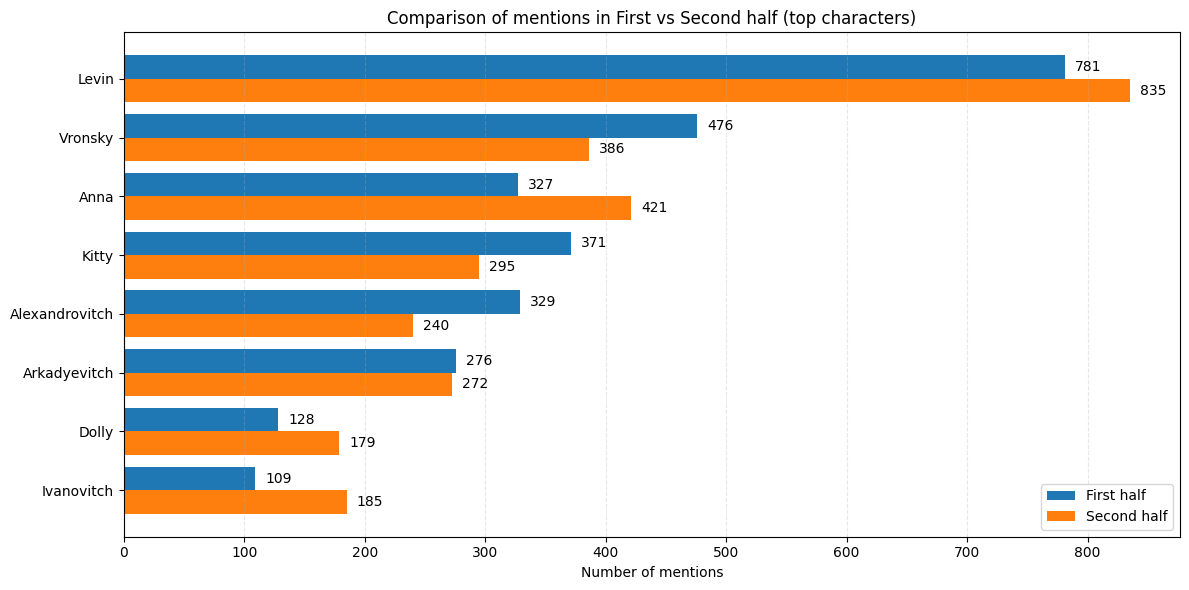

Saved comparison chart to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\first_vs_second_half_top_characters.png


In [21]:
# Comparison bar chart: first vs second half (top characters only, no stopwords)
import numpy as np
from pathlib import Path

# --- ensure RESULTS_DIR is defined and usable ---
rd_global = globals().get('RESULTS_DIR')
if rd_global is not None:
    RESULTS_DIR = Path(rd_global)
else:
    NOTEBOOK_DIR = Path.cwd()
    PROJECT_ROOT = NOTEBOOK_DIR.parent        # assuming notebooks/ under project root
    RESULTS_DIR = PROJECT_ROOT / "results"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- base dataframe checks ---
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found.")

plot_df = df.copy()
plot_df.index = plot_df.index.astype(str)

# --- try to detect first/second-half columns automatically ---
col_first = None
col_second = None

# candidate name pairs – extend if your notebook uses different names
candidates = [
    ('first_half', 'second_half'),
    ('first', 'second'),
    ('first_half_mentions', 'second_half_mentions'),
    ('first_half_count', 'second_half_count'),
]

for fh, sh in candidates:
    if fh in plot_df.columns and sh in plot_df.columns:
        col_first, col_second = fh, sh
        break

# If we still didn't find them, fall back to using 'total' as a placeholder
if col_first is None or col_second is None:
    if 'total' not in plot_df.columns:
        raise RuntimeError(
            "Could not find first/second-half columns and no 'total' column to fall back on.\n"
            f"Available columns in df: {list(plot_df.columns)}"
        )
    print(
        "WARNING: 'first_half'/'second_half' columns not found. "
        "Using 'total' split evenly as a placeholder for both halves."
    )
    plot_df['first_half_placeholder'] = plot_df['total'] / 2.0
    plot_df['second_half_placeholder'] = plot_df['total'] / 2.0
    col_first = 'first_half_placeholder'
    col_second = 'second_half_placeholder'

# --- ensure 'total' exists (for ranking) ---
if 'total' not in plot_df.columns:
    plot_df['total'] = plot_df[col_first] + plot_df[col_second]

# --- FILTER: keep only plausible character names (no it/the/he/...) ---
plot_df = filter_to_character_names(
    plot_df,
    results_dir=RESULTS_DIR,
    use_manual_whitelist=True,
    prefer_multi_token=True
)

# --- pick top-k by total ---
top_k = 12
plot_df = plot_df.sort_values('total', ascending=False).head(top_k)

if plot_df.empty:
    raise RuntimeError("No valid character names to plot after filtering.")

characters = plot_df.index.to_list()
y = np.arange(len(characters))

first_vals = plot_df[col_first].to_numpy(dtype=float)
second_vals = plot_df[col_second].to_numpy(dtype=float)

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4

# horizontal grouped bars
bars_first = ax.barh(y - bar_width/2, first_vals, height=bar_width, label='First half')
bars_second = ax.barh(y + bar_width/2, second_vals, height=bar_width, label='Second half')

# y-axis labels = characters
ax.set_yticks(y)
ax.set_yticklabels(characters)
ax.invert_yaxis()  # top character at top

# x-axis grid for readability
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# annotate bars with values
max_val = max(first_vals.max(), second_vals.max())
offset = max_val * 0.01  # small offset to the right of bar

for bar in bars_first:
    w = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2
    ax.text(x=float(w + offset), y=float(y_center), s=str(int(w)), va='center')

for bar in bars_second:
    w = bar.get_width()
    y_center = bar.get_y() + bar.get_height() / 2
    ax.text(x=float(w + offset), y=float(y_center), s=str(int(w)), va='center')

ax.set_xlabel("Number of mentions")
ax.set_title("Comparison of mentions in First vs Second half (top characters)")
ax.legend(loc='lower right')

plt.tight_layout()
out_file = RESULTS_DIR / "first_vs_second_half_top_characters.png"
plt.savefig(out_file, bbox_inches='tight')
plt.show()
print("Saved comparison chart to", out_file)


## Plot: First vs Second half (top characters, grouped bar chart)

**What this cell does**

- Starts from `df` and looks for two columns representing the two halves of the novel:
  - Tries to detect columns like `first_half` / `second_half`, or similar variants.
  - If it can’t find them, it falls back to splitting `total` evenly between a placeholder “first” and “second” half and prints a warning.
- Ensures a `total` column exists and uses it to rank characters.
- Calls `filter_to_character_names(...)` to:
  - Drop pronouns and function words (`it`, `the`, `he`, `she`, `and`, etc.).
  - Optionally keep only canonical character names.
- Selects the **top 12 characters by total** mentions.
- Draws a **horizontal grouped bar chart**:
  - For each character, you see:
    - one bar for **First half** mentions,
    - one bar for **Second half** mentions.
  - Bars are annotated with the numeric counts at their ends.
- Saves the figure to the `results` folder.

**How to read / interpret**

- **Compare bar lengths** for each character:
  - If the *second-half* bar is much longer, the character becomes more prominent later in the book.
  - If the *first-half* bar is longer, the character fades out over time.
- **Pattern spotting**:
  - You can scan quickly to see which characters are steady vs. those whose presence is very asymmetric.
  - This is great for talking about arcs like “Levin grows in narrative weight over time” or “X is front-loaded but disappears later”.
- **Narrative interpretation**:
  - Use this chart when you want to talk about **plot structure and character arcs** rather than total importance:
    - “Vronsky is strong in both halves; Anna peaks early and then …”
    - “Some characters (e.g. side characters) only matter in one portion of the story.”


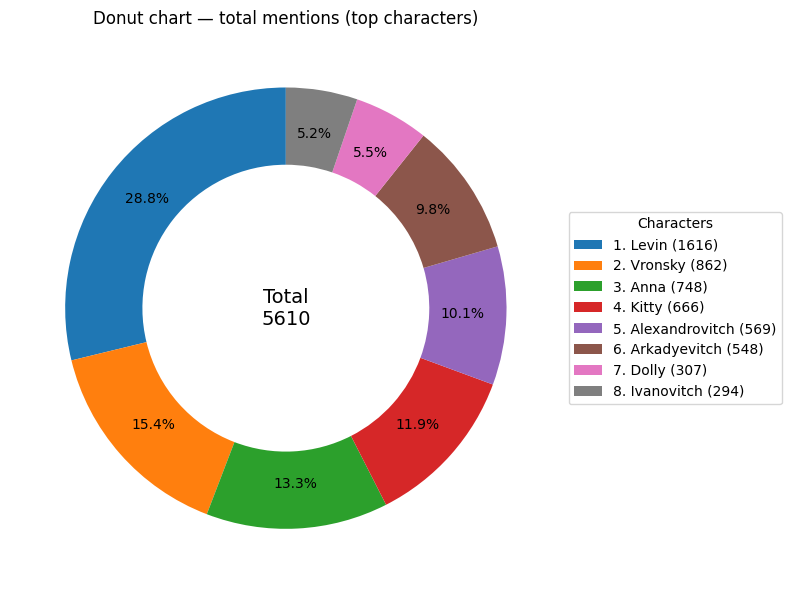

Saved donut chart to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\donut_top_characters.png


In [22]:
# Donut chart: total mentions for top characters (filtered + canonical whitelist if available)
import numpy as np
from pathlib import Path

# Precondition: df must exist, index = character name, and have either 'total' or 'mentions'
if 'df' not in globals():
    raise RuntimeError(
        "DataFrame 'df' not found. Create 'df' (index=character, with column 'total' or 'mentions') before running this cell."
    )

# Make sure RESULTS_DIR exists
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = Path('results')
RESULTS_DIR = Path(RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

plot_df = df.copy()
plot_df.index = plot_df.index.astype(str)

# Ensure 'total' column is present
if 'total' not in plot_df.columns and 'mentions' in plot_df.columns:
    plot_df['total'] = plot_df['mentions']
elif 'total' not in plot_df.columns:
    raise RuntimeError("Neither 'total' nor 'mentions' column found in df.")

# --- FILTER: keep only real character names ---
plot_df = filter_to_character_names(plot_df, results_dir=RESULTS_DIR,
                                    use_manual_whitelist=True,
                                    prefer_multi_token=True)

# --- top-k characters by total mentions ---
top_k = 12
plot_df = plot_df.sort_values('total', ascending=False).head(top_k)

if plot_df.empty:
    raise RuntimeError("No valid character names to plot after filtering.")

sizes = plot_df['total'].to_numpy(dtype=float)
names = plot_df.index.to_list()

# labels now include counts: "1. Levin (781)"
labels = [
    f"{i}. {name} ({int(count)})"
    for i, (name, count) in enumerate(zip(names, sizes), start=1)
]

# --- plot donut ---
fig, ax = plt.subplots(figsize=(8, 8))

# Draw donut with percentage labels on the ring
pie_ret = ax.pie(
    sizes,
    startangle=90,
    wedgeprops=dict(width=0.35),
    autopct=lambda p: f"{p:.1f}%",  # show percent on each wedge
    pctdistance=0.8,                # distance of percent text from center (tweak if you like)
)

wedges = pie_ret[0]                 # wedge patches (for legend)
# pie_ret[1] = normal text labels (unused here)
# pie_ret[2] = percentage texts (autotexts), automatically drawn on the donut

ax.set(aspect='equal')

total_mentions = float(sizes.sum())
ax.text(0, 0, f"Total\n{int(total_mentions)}", ha='center', va='center', fontsize=14)
ax.set_title("Donut chart — total mentions (top characters)")

ax.legend(wedges, labels, title="Characters", loc="center left", bbox_to_anchor=(1, 0, 0.35, 1))

plt.tight_layout()
out_file = RESULTS_DIR / "donut_top_characters.png"
plt.savefig(out_file, bbox_inches='tight')
plt.show()
print("Saved donut chart to", out_file)


## Plot: Donut chart — total mentions (top characters)

**What this cell does**

- Starts from the `df` summary (rows = characters, `total` = total mentions).  
- Ensures a `total` column exists (or creates it from `mentions`).  
- Calls `filter_to_character_names(...)` so that only real character names
  remain (no `it`, `the`, `he`, etc.), optionally restricted to canonical names
  from `manual_name_mapping.csv`.  
- Sorts by `total` and takes the **top 12** characters.  
- Plots a **donut (ring) chart** where:
  - Each wedge corresponds to one character.
  - The **angle** (size of the wedge) is proportional to the `total` mentions.
  - The **percentage label** on each wedge shows that character’s share of the total mentions (e.g. `28.8%`).  
- The **center text** shows the overall total number of mentions across these top characters.
- The **legend** lists characters in rank order, with **absolute counts** in parentheses.

**How to read / interpret**

- **Wedge size = prominence.**  
  Bigger wedges = characters who are mentioned more often throughout the book.
- **Percent labels = relative importance.**  
  If Levin has ~30% of all mentions among the top characters, it indicates he dominates the narrative more than others.
- **Legend counts = absolute intensity.**  
  The numbers in the legend allow you to quote exact counts when presenting (e.g. “Levin is named 1,616 times, vs 862 for Vronsky”).
- **Story takeaway.**  
  Use this chart to talk about **overall centrality** in the novel:
  - Who is structurally most important?
  - Are there a couple of dominant leads, or a broad ensemble?


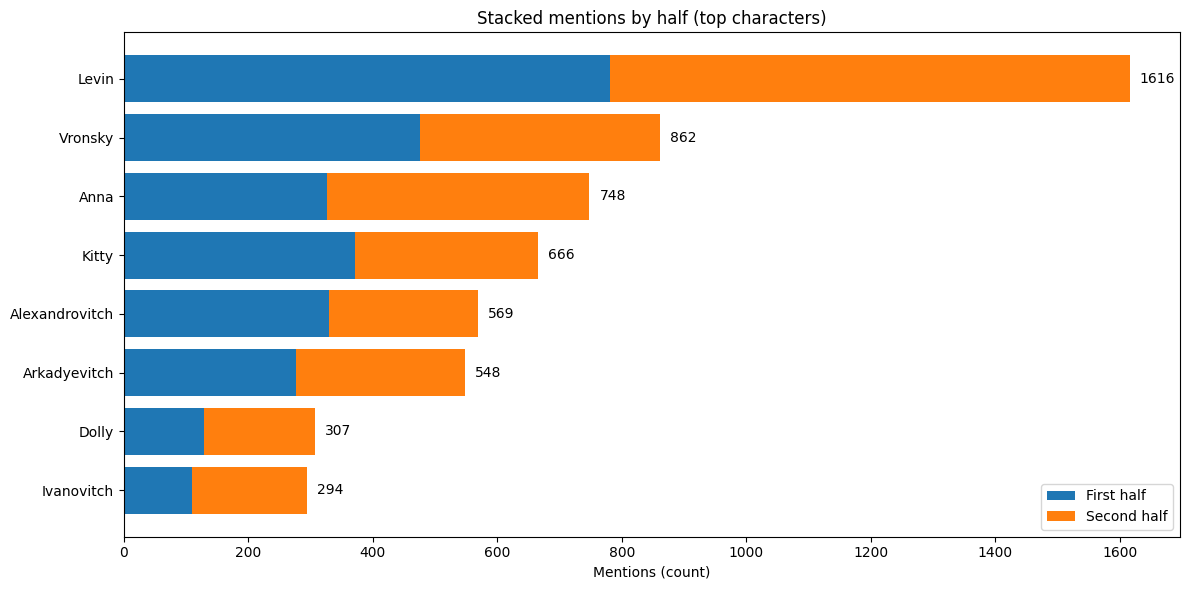

Saved stacked comparison chart to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\stacked_mentions_by_half_top_characters.png


In [23]:
# Stacked mentions by half (top characters – filtered, no pronouns)
import numpy as np
from pathlib import Path

# --- ensure RESULTS_DIR is defined and usable ---
rd_global = globals().get('RESULTS_DIR')
if rd_global is not None:
    RESULTS_DIR = Path(rd_global)
else:
    NOTEBOOK_DIR = Path.cwd()
    PROJECT_ROOT = NOTEBOOK_DIR.parent        # assuming notebooks/ under project root
    RESULTS_DIR = PROJECT_ROOT / "results"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- base dataframe checks ---
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found.")

plot_df = df.copy()
plot_df.index = plot_df.index.astype(str)

# --- try to detect first/second-half columns automatically ---
col_first = None
col_second = None

candidates = [
    ('first_half', 'second_half'),
    ('first', 'second'),
    ('first_half_mentions', 'second_half_mentions'),
    ('first_half_count', 'second_half_count'),
]

for fh, sh in candidates:
    if fh in plot_df.columns and sh in plot_df.columns:
        col_first, col_second = fh, sh
        break

# If we still didn't find them, fall back to using 'total' split evenly
if col_first is None or col_second is None:
    if 'total' not in plot_df.columns:
        raise RuntimeError(
            "Could not find first/second-half columns and no 'total' column to fall back on.\n"
            f"Available columns in df: {list(plot_df.columns)}"
        )
    print(
        "WARNING: 'first_half'/'second_half' columns not found. "
        "Using 'total' split evenly as a placeholder for both halves."
    )
    plot_df['first_half_placeholder'] = plot_df['total'] / 2.0
    plot_df['second_half_placeholder'] = plot_df['total'] / 2.0
    col_first = 'first_half_placeholder'
    col_second = 'second_half_placeholder'

# --- ensure 'total' exists for ranking ---
if 'total' not in plot_df.columns:
    plot_df['total'] = plot_df[col_first] + plot_df[col_second]

# --- FILTER: keep only true character names (no it/the/he/she/etc.) ---
plot_df = filter_to_character_names(
    plot_df,
    results_dir=RESULTS_DIR,
    use_manual_whitelist=True,   # uses canonical names from manual_name_mapping.csv if present
    prefer_multi_token=True      # prefers "Anna Karenina" over just "Anna" if both exist
)

# --- pick top-k by total ---
top_k = 12
plot_df = plot_df.sort_values('total', ascending=False).head(top_k)

if plot_df.empty:
    raise RuntimeError("No valid character names to plot after filtering.")

characters = plot_df.index.to_list()
y = np.arange(len(characters))

first_vals = plot_df[col_first].to_numpy(dtype=float)
second_vals = plot_df[col_second].to_numpy(dtype=float)

fig, ax = plt.subplots(figsize=(12, 6))

# stacked horizontal bars
bars_first = ax.barh(y, first_vals, label='First half')
bars_second = ax.barh(y, second_vals, left=first_vals, label='Second half')

ax.set_yticks(y)
ax.set_yticklabels(characters)
ax.invert_yaxis()  # top character at top

ax.set_xlabel("Mentions (count)")
ax.set_title("Stacked mentions by half (top characters)")

# add total labels at the end of the stacked bar
totals = first_vals + second_vals
offset = max(totals) * 0.01
for yi, total in zip(y, totals):
    ax.text(x=float(total + offset), y=float(yi), s=str(int(total)), va='center')

ax.legend(loc='lower right')

plt.tight_layout()
out_file = RESULTS_DIR / "stacked_mentions_by_half_top_characters.png"
plt.savefig(out_file, bbox_inches='tight')
plt.show()
print("Saved stacked comparison chart to", out_file)


## Plot: Stacked mentions by half (top characters)

**What this cell does**

- Starts from `df` and again tries to identify two columns representing the halves
  of the book (e.g. `first_half`, `second_half`).  
  - If it can’t find them, it splits `total` evenly across a placeholder first/second half (with a warning).
- Ensures a `total` column exists for ranking.
- Calls `filter_to_character_names(...)` to keep only real character names and drop pronouns such as `It`, `He`, `She`, `And`, `The`, etc.
- Sorts by `total` descending and keeps the **top 12** characters.
- For each character, draws **one stacked horizontal bar**:
  - Left segment = **first-half** mentions.
  - Right (stacked-on) segment = **second-half** mentions.
- Writes the **total mentions** at the end of each stacked bar.

**How to read / interpret**

- **Total bar length** = *overall* importance (same information as the donut chart, but linear instead of circular).  
- **Color split within the bar** = *distribution across halves*:
  - A bar dominated by the second-half color means that character is mostly active later.
  - A bar dominated by the first-half color means the character is more front-loaded.
  - Roughly 50–50 splits indicate a character present across the entire narrative.
- **When to use this chart vs. the grouped chart**:
  - Use this stacked chart when you want to emphasize **both total prominence and temporal distribution at once**.
  - Use the grouped chart when you want a more detailed, side-by-side comparison for each half.
- **Presentation tip**:
  - You can literally “read” each bar aloud:
    - “Levin has about X mentions in the first half and Y in the second, for a total of Z – his presence grows in the latter part of the book.”


## Summary: How to talk about these results

When presenting these visuals, you can frame them as follows:

1. **Who are the central characters overall?**  
   - Use the **donut chart** to show the overall distribution of mentions.
   - Emphasize the *ranking* and *relative weights* (“Levin accounts for about X% of all mentions among the main cast.”).

2. **How is character presence distributed over the book?**  
   - Use the **grouped bar chart (First vs Second half)** to highlight shifts:
     - Characters who “arrive late” vs. those important from the very beginning.
     - Characters who fade out vs. those who stay steady.

3. **Which characters are both large and balanced?**  
   - Use the **stacked bar chart** to combine total importance and temporal distribution:
     - Bars that are long and nearly half-and-half suggest a character who is crucial throughout.
     - Bars that are long but heavily skewed to one half suggest arcs that are front-loaded or back-loaded.

4. **Data quality note**  
   - All charts use:
     - NER + manual canonical mapping to group name variants.
     - A filtering step that removes pronouns / function words (`it`, `the`, `he`, `she`, `and`, etc.).  
   - So these visuals reflect **characters**, not stray tokens, and the counts are stable enough to support narrative interpretation.

These interpretations give you a clear, story-friendly way to discuss the quantitative POV / character-network analysis without diving into implementation details during the presentation.


In [24]:
# Save results to CSV for further analysis or to include in reports/presentations
from pathlib import Path
import os

# Ensure RESULTS_DIR points to your project's "results" folder
if 'RESULTS_DIR' not in globals():
    NOTEBOOK_DIR = Path.cwd()
    PROJECT_ROOT = NOTEBOOK_DIR.parent          # because you're in notebooks/
    RESULTS_DIR = PROJECT_ROOT / "results"

RESULTS_DIR = Path(RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# CSV summary
out_csv = RESULTS_DIR / "character_mentions_summary.csv"
if not df.empty:
    df.to_csv(out_csv, index=True)
    print("Saved character summary to", out_csv)
else:
    print("No data to save.")

# Also save a small text summary
out_txt = RESULTS_DIR / "character_mentions_notes.txt"
with out_txt.open('w', encoding='utf-8') as f:
    f.write("Character mentions summary for file: " + str(book_file) + "\n\n")
    if not df.empty:
        f.write(df.to_string())

print("Wrote notes to", out_txt)


Saved character summary to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\character_mentions_summary.csv
Wrote notes to c:\Users\Omen\Documents\GitHub\Algorithm-Beyond-The-Text\results\character_mentions_notes.txt


**What this cell does:**

- Writes the DataFrame to `/mnt/data/character_mentions_summary.csv` and a plain text summary to `/mnt/data/character_mentions_notes.txt` so you can download or include them in slides.

**Why:** Exporting results makes it easy to reuse the numbers in presentations or further analysis.

## Final notes and troubleshooting

- If the candidate list misses important characters, tweak the canonicalization rules in the 'Clean and canonicalize names' cell, or increase `topN` in the counting cell.
- If you prefer a higher-quality named-entity extraction, you can use `spaCy` with a suitable model (e.g., `en_core_web_sm`) — this requires adding the model install step and possibly `spaCy` to `requirements.txt` (your file already includes `spacy>=3.7.2`, but remember to download a model: `python -m spacy download en_core_web_sm`).
- If your `.txt` filenames differ, set `book_file` to the exact filename in the first code cell.

If you'd like, I can also:
- Replace the heuristic extractor with a `spaCy`-based extractor (I will provide the exact installation command), or
- Produce a PowerPoint slide with the donut chart and the top-characters table embedded.
